# Plot eddy momentum fluxes ( u-direction)

In [41]:
from netCDF4 import Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
import decomp_alllevels as deco
from imp import reload
import write_netCDF as write
import amoc_plots as aplot
import tools
import xz_tools as xz_tools
import numpy.ma as ma
from scipy.interpolate import interp1d
import matplotlib.colors as mplc

In [42]:
########### CHOOSE CASE #########
case="10S"
#################################

########### CHOOSE TIME #########
time="2000s"
#################################


path=tools.case_path(case,time)
os.chdir(path)

In [43]:
divUu = tools.netread_data("../div_Uu_eddy_stripe.nc","div_Uu_eddy") # eddy flux divergence
vke = tools.netread_data('../vke_p_stripe.nc','vke') # vke
uko = tools.netread_data('../uko_p_stripe.nc','uko') # vke
rho = tools.netread_data('../rhopoto_stripe.nc','rhopoto') # density
lat,lon,depth = tools.netread_grid('../rhopoto_stripe.nc','lat','lon','depth_14')
nx = tools.netread_data('../dxN_vel_hor_mag_stripe.nc','dx_vel_hor_mag') # normal vector x-comp
ny = tools.netread_data('../dyN_vel_hor_mag_stripe.nc','dy_vel_hor_mag') # normal vector y-comp
fvag = tools.netread_data('../fvag_stripe.nc','fvag')
U_grad_u = tools.netread_data('../U_grad_u_stripe.nc','momentum_advection_u')

ztop 	= 500.
zbot	= 4000.

ktop,kbot,k2k = tools.depths_xz_sections(ztop,zbot,depth)

lx,rx,llon,rlon= tools.case_region(case)

lat2 = lat[:,lx:rx]
lon2 = lon[:,lx:rx]
vke2 = vke[:,:,lx:rx]
uko2 = uko[:,:,lx:rx]
rho2 = rho[:,:,lx:rx]
divUu2 = divUu[:,:,lx:rx]
nx2 = 1*nx[:,:,lx:rx]
ny2 = 1*ny[:,:,lx:rx]
fvag2=1*fvag[:,:,lx:rx]
U_grad_u2=1*U_grad_u[:,:,lx:rx]

llon2 = llon-lx
rlon2 = llon-lx + (rlon -llon)

dist = np.zeros((lon[0,llon:rlon].shape))
for i in range(len(dist)):
    dist[i] = i * 11.113
    # Get distance from coast from lon:


x,z = np.meshgrid(dist,depth[ktop:kbot])
clines2,maxpos = tools.clines_from_uko_vke(kbot,ktop,k2k,uko,uko2,vke2)

/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:6457: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [44]:
normal, tangent = deco.read_normal_get_tangent(nx2,ny2,clines2,k2k)
upar,uper,minimalj = deco.decomposition_little_sophisticated(uko2,vke2,tangent,normal,lon2,lat2,clines2,ktop,kbot)


/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3158: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dout = self.data[indx]
/sw/rhel6-x64/python/python-3.5.2-gcc49/lib/python3.5/site-packages/numpy-1.11.2-py3.5-linux-x86_64.egg/numpy/ma/core.py:3174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  elif _mask is not nomask and _mask[indx]:


In [62]:
#reload(xz_tools)
lat_from = -11
lat_to = -12

mean_upar,data_upar = xz_tools.along_average(upar,upar,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_divUu,data_divUu = xz_tools.along_average(upar,divUu2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_rho,data_rho = xz_tools.along_average(upar,rho2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_vke,data_vke = xz_tools.along_average(upar,vke2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_fvag,data_fvag = xz_tools.along_average(upar,fvag2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)
mean_U_grad_u,data_U_grad_u = xz_tools.along_average(upar,U_grad_u2,ktop,kbot,k2k,llon2,rlon2,maxpos,lat2,lat_from,lat_to)

data_rho_ = data_rho.copy()
data_rho  = np.ma.masked_where(data_rho == 0, data_rho_,copy=True)

data_upar_ = data_upar.copy()
data_upar =  np.ma.masked_where(data_rho.mask==True, data_upar_, copy=True)

data_divUu_ = data_divUu.copy()
data_divUu =  np.ma.masked_where(data_rho.mask==True, data_divUu_, copy=True)

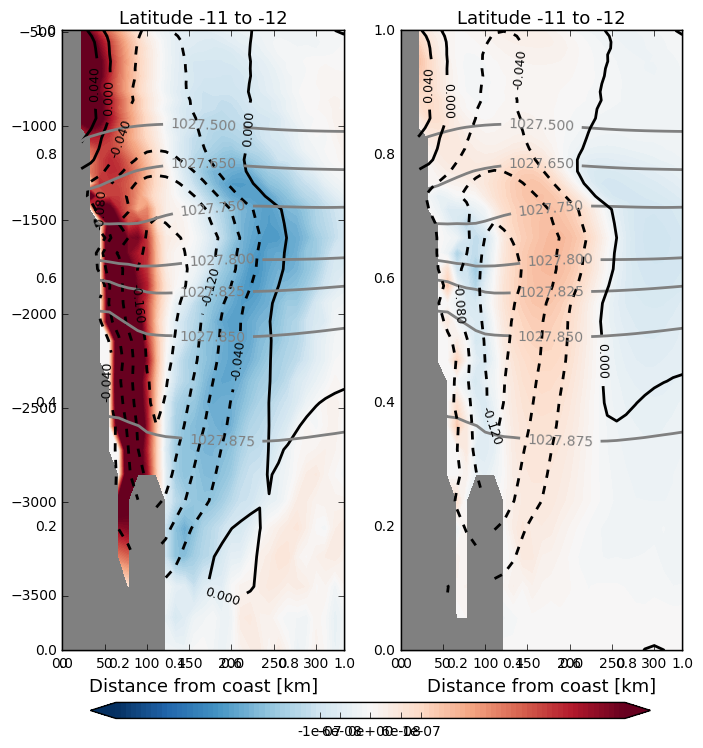

In [64]:
fig=plt.figure(figsize=(8,8))
plt.subplot(121)
a=fig.add_subplot(121,axisbg='grey')
#a=fig.add_subplot(111,axisbg='grey')
plt.title("Latitude " + str(lat_from) + " to " + str( lat_to ),fontsize=13)
plt.xlabel("Distance from coast [km]",fontsize=13)
#plt.ylabel("Depth [m]",fontsize=13)
#plt.yticks([-1100,-1500,-1900,-2300,-2700,-3100])
high=5e-7
#high=0.9e-8
w=(-0.2,-0.16,-0.12,-0.08,-0.04,0,0.04)
fvke = plt.contour(x, -z, data_upar, w,colors='k', linewidths=2)  # negative contours will be dashed by default
plt.clabel(fvke, fontsize=9, inline=1)
v =  np.linspace(-high,high,100)
w = (1027.5,1027.65,1027.75,1027.8,1027.825,1027.85,1027.875)
frho = plt.contour(x,-z,data_rho, w, colors='grey', linewidths=2)
plt.clabel(frho, fontsize=10, inline=1,colors="grey",styles="oblique")
fdiv=plt.contourf(x,-z,data_fvag,v,extend="both")
#fdiv=plt.contourf(x,-z,data_U_grad_v,v,extend="both")
fig_coord = [0.16,0.04,0.7,0.02]
cbar_ax = fig.add_axes(fig_coord)
plt.colorbar(ticks=[-1e-7,-6e-8,0,6e-8,1e-7],format='%.0e',orientation="horizontal",cax=cbar_ax)
plt.set_cmap("RdBu_r")
tmp1 = np.int64(lat_from)
tmp2 = np.int64(lat_to)

plt.subplot(122)
a=fig.add_subplot(122,axisbg='grey')
plt.title("Latitude " + str(lat_from) + " to " + str( lat_to ),fontsize=13)
plt.xlabel("Distance from coast [km]",fontsize=13)
#plt.ylabel("Depth [m]",fontsize=13)
plt.yticks([])
w = (1027.5,1027.65,1027.75,1027.8,1027.825,1027.85,1027.875)
frho = plt.contour(x,-z,data_rho, w, colors='grey', linewidths=2)
plt.clabel(frho, fontsize=10, inline=1,colors="grey",styles="oblique")
high=5e-7
#high=0.9e-8
w=np.linspace(-high,high,100)
fvke = plt.contourf(x, -z, data_divUu, w,extend="both")
#fvke = plt.contourf(x, -z, data_divUv, w,extend="both")
#plt.colorbar()
w=(-0.2,-0.16,-0.12,-0.08,-0.04,0,0.04)
fvke = plt.contour(x, -z, data_vke, w,colors='k', linewidths=2)  # negative contours will be dashed by default
plt.clabel(fvke, fontsize=9, inline=1)
#plt.savefig("/work/mh0256/m300522/data_storm/eddies/2000s/figs/fdiffu_divUv"+str(np.int64(lat_from))+"to"+str(np.int64(lat_to))+".png",bbox_inches = 'tight')
plt.show()

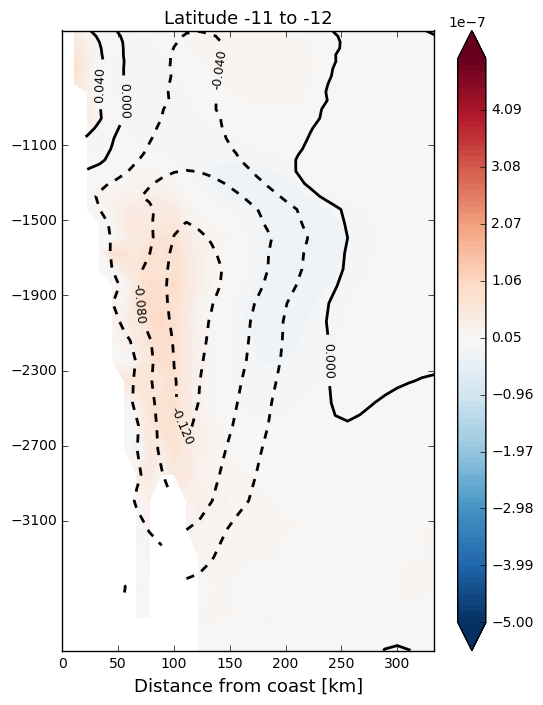

In [66]:
fig=plt.figure(figsize=(6,8))
plt.title("Latitude " + str(lat_from) + " to " + str( lat_to ),fontsize=13)
plt.xlabel("Distance from coast [km]",fontsize=13)
#plt.ylabel("Depth [m]",fontsize=13)
plt.yticks([-1100,-1500,-1900,-2300,-2700,-3100])
high=5e-7
#high=0.9e-8
w=np.linspace(-high,high,100)
fvke = plt.contourf(x, -z,data_U_grad_u, w,extend="both")
plt.colorbar()
w=(-0.2,-0.16,-0.12,-0.08,-0.04,0,0.04)
fvke = plt.contour(x, -z, data_vke, w,colors='k', linewidths=2)  # negative contours will be dashed by default
plt.clabel(fvke, fontsize=9, inline=1)
#plt.savefig("geostrophic_error"+str(np.int64(lat_from))+"to"+str(np.int64(lat_to))+".png",bbox_inches = 'tight')
plt.show()